In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
for C in enumerate(train_iter):
    print(C)

(0, (tensor([[ 2,  1, 21,  ..., 10,  1, 16],
        [12,  2,  8,  ..., 10,  1, 18],
        [ 2, 16,  5,  ..., 10,  2, 11],
        ...,
        [ 1,  9,  4,  ...,  2,  1,  9],
        [14, 21,  8,  ..., 15,  5,  3],
        [ 6,  1,  9,  ...,  6,  1,  3]]), tensor([[ 1, 21, 19,  ...,  1, 16,  7],
        [ 2,  8,  1,  ...,  1, 18, 12],
        [16,  5,  6,  ...,  2, 11,  1],
        ...,
        [ 9,  4, 11,  ...,  1,  9,  4],
        [21,  8,  3,  ...,  5,  3,  1],
        [ 1,  9,  2,  ...,  1,  3,  9]])))
(1, (tensor([[ 7, 10,  1,  ..., 20,  2,  4],
        [12,  4,  8,  ...,  6,  3,  8],
        [ 1,  9,  5,  ...,  4, 10,  4],
        ...,
        [ 4, 11,  1,  ...,  1,  3, 10],
        [ 1, 16,  7,  ...,  1,  2, 24],
        [ 9,  2,  1,  ...,  1, 17,  4]]), tensor([[10,  1,  8,  ...,  2,  4, 23],
        [ 4,  8,  8,  ...,  3,  8,  1],
        [ 9,  5,  8,  ..., 10,  4, 11],
        ...,
        [11,  1, 16,  ...,  3, 10,  4],
        [16,  7, 10,  ...,  2, 24, 20],
        [ 2

In [3]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [5]:
def rnn(inputs, state, params):
    # `inputs`的形状： (`时间步数量`， `批量⼤⼩`， `词表⼤⼩`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # `X`的形状： (`批量⼤⼩`， `词表⼤⼩`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [6]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经⽹络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
    init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [7]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
init_rnn_state, rnn)
X = torch.arange(10).reshape((2, 5))
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [8]:
def predict_ch8(prefix, num_preds, net, vocab, device): #@save
    """在`prefix`后⾯⽣成新字符。 """
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
    (1, 1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [9]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller ztowe ftop'

In [10]:
def grad_clipping(net, theta): #@save
    """裁剪梯度。 """
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [11]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型⼀个迭代周期（定义⻅第8章）。 """
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第⼀次迭代或使⽤随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调⽤了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
    use_random_iter=False):
    """训练模型（定义⻅第8章）。 """
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                                                legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                    use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 125642.2 词元/秒 cuda:0
time travellerit s against reason said filbywhat ga mantearnestn
traveller with a slight accession ofcheerfulness really thi


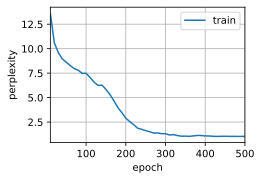

In [12]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 128837.8 词元/秒 cuda:0
time travellerit s against reason said filbywhat eers but lergan
travellerit s against reason said filbywhat eers but lergan


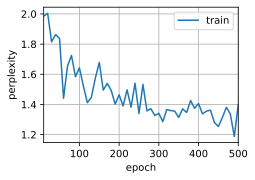

In [13]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
use_random_iter=True)